### Εκπαίδευση και αξιολόγηση ANN, GNN, GCN και GAT σε γλώσσα Python

Σε αυτό το notebook θα εκπαιδεύσουμε και θα αξιολογήσουμε 4 πολύ γνωστές αρχιτεκτονικές τεχνητών νευρωνικών δικτύων.

- Artificial Neural Network (ANN)

- Graph Neural Network (GNN)

- Graph Convolutional Neural Network (GCN)

- Graph Attention Network (GAT)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import degree
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATv2Conv, GCNConv
from torch.nn import Linear, Dropout
import networkx as nx
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

### Cora dataset

Αρχικά θα πρέπει να φορτώσουμε το σύνολο δεδομένων το οποίο θα χρησιμοποιήσουμε. Πρόκειται για το Cora dataset, το πιο γνωστό σύνολο δεδομένων για node classification. Το dataset αυτό αντιπροσωπεύει ένα δίκτυο από 2.708 επιστημονικές δημοσιεύσεις όπου κάθε σύνδεση/ακμή είναι ένα reference. Κάθε δημοσίευση περιγράφεται από ένα δυαδικό διάνυσμα 1.433 μοναδικών λέξεων όπου τα 0 και 1 υποδεικνύουν την παρουσία ή την απουσία μιας λέξης αντίστοιχα.

In [2]:
# Μπορούμε να τυπώσουμε συγκεκριμένα χαρακτηριστικά του γράφου
dataset = Planetoid(root=".", name="Cora")

data = dataset[0]

# Τυπώνουμε στοιχεία που αφορούν γενικά στο σύνολο δεδομένων (μπορεί να αποτελείται από > 1 γράφους)
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Τυπώνουμε στοιχεία που αφορούν σε έναν συγκεκριμένο γράφο (στην περίπτωση του cora dataset, μόνο ένας γράφος υπάρχει στο σύνολο δεδομένων)
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


Processing...
Done!


In [3]:
total_rows = 2708

# Calculate the number of rows in each subset
train_count = int(0.70 * total_rows)  # 70% για εκπαίδευση
val_count = int(0.15 * total_rows)  # 15% για έλεγχο
test_count = total_rows - train_count - val_count  # Το υπόλοιπο για αξιολόγηση

# Ορίζουμε συγκεκριμένα εύρη για τις μάσκες που θα χρησιμοποιήσουμε έτσι ώστε να χωρίσουμε το σύνολο δεδομένων
data.train_mask = range(train_count)
data.val_mask = range(train_count, train_count + val_count)
data.test_mask = range(train_count + val_count, total_rows)

Παρακάτω βλέπουμε μια οπτικοποίηση των κόμβων του γράφου της pubmed

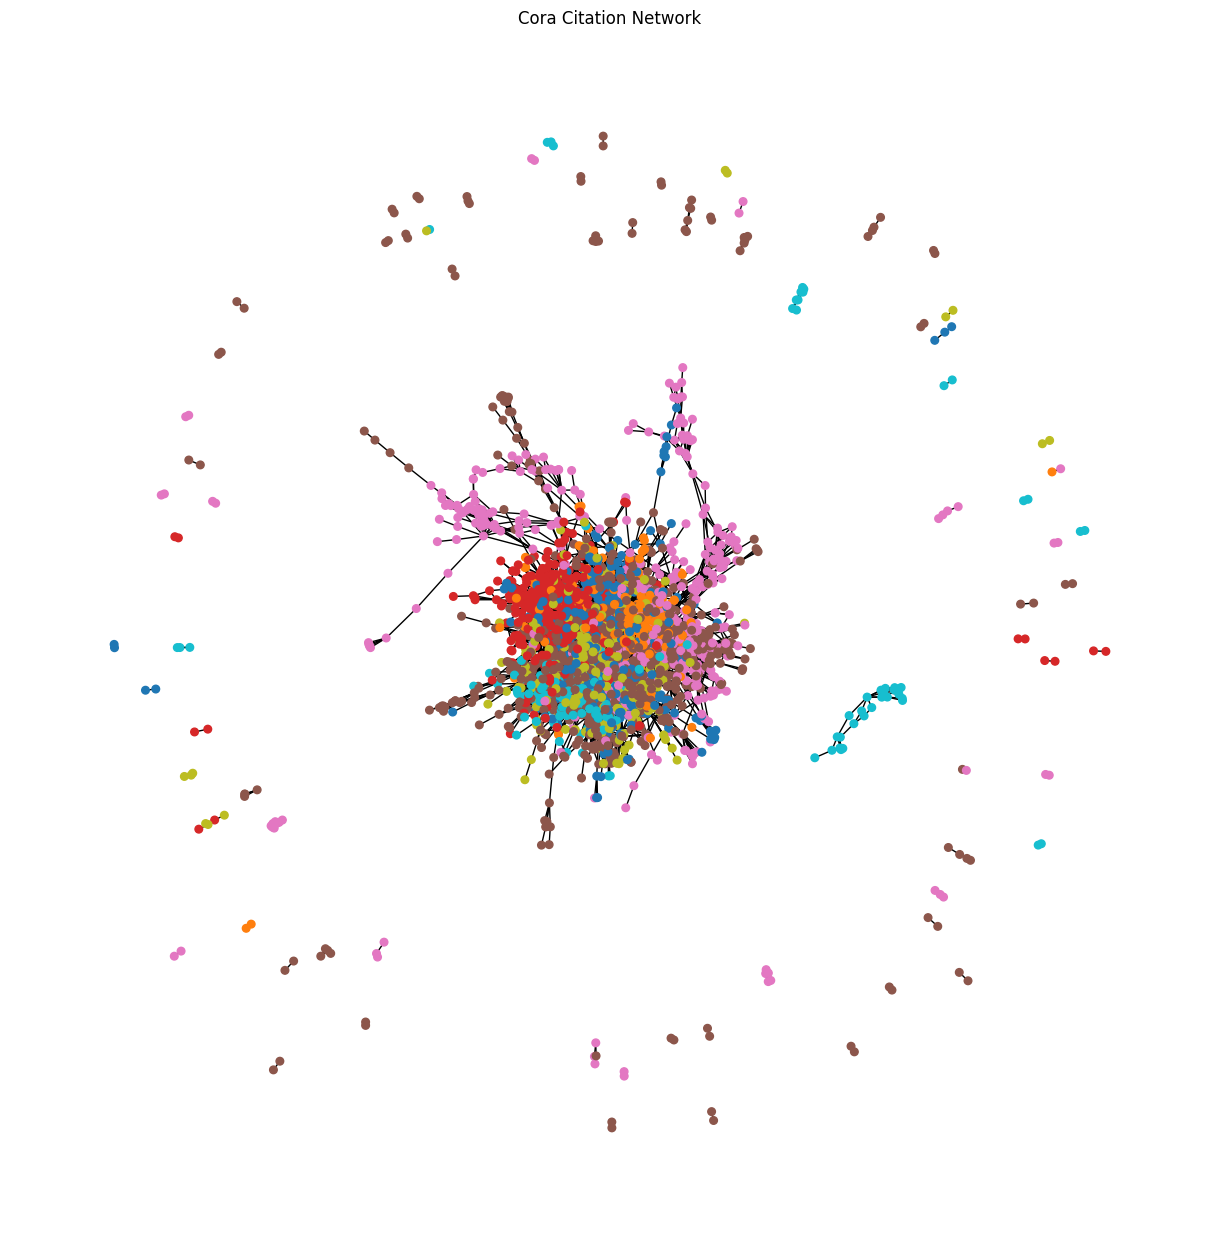

In [5]:
# Convert the graph to a NetworkX graph object
G = to_networkx(data, to_undirected=True)
# Draw the graph
plt.figure(figsize=(12, 12))
colors = [data.y[i].item() for i in G.nodes()]  # Node colors by label
nx.draw(G, node_color=colors, node_size=30, cmap=plt.get_cmap('tab10'), with_labels=False)
plt.title('Cora Citation Network')
plt.show()

<!-- ![title](./pubmed_dataset.png) -->

Μπορούμε να δούμε το dataset και σε μορφή πίνακα

In [1]:
df_x = pd.DataFrame(data.x.numpy())
df_x['label'] = pd.DataFrame(data.y)
df_x

![alternative text](./cora_tabular.png)

### Δημιουργία, εκπαίδευση και αξιολόγηση κλασικού Artificial Neural Network

In [7]:
torch.manual_seed(0)

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, dim_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create MLP model
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)

# Train
mlp.fit(data, epochs=100)

# Test
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=1433, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=7, bias=True)
)
Epoch   0 | Train Loss: 1.999 | Train Acc: 12.30% | Val Loss: 1.96 | Val Acc: 20.69%
Epoch  20 | Train Loss: 0.428 | Train Acc: 92.03% | Val Loss: 0.98 | Val Acc: 67.73%
Epoch  40 | Train Loss: 0.084 | Train Acc: 99.53% | Val Loss: 0.98 | Val Acc: 70.94%
Epoch  60 | Train Loss: 0.054 | Train Acc: 100.00% | Val Loss: 1.02 | Val Acc: 69.70%
Epoch  80 | Train Loss: 0.048 | Train Acc: 100.00% | Val Loss: 1.04 | Val Acc: 70.20%
Epoch 100 | Train Loss: 0.041 | Train Acc: 100.00% | Val Loss: 1.07 | Val Acc: 69.46%

MLP test accuracy: 75.92%


Παρατηρούμε ότι έχουμε ένα test accuracry της τάξεως του 76%. Ας δοκιμάσουμε να χρησιμοποιήσουμε ένα graph neural network

In [8]:
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x

In [2]:
from torch_geometric.utils import to_dense_adj

adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))

### Δημιουργία, εκπαίδευση & αξιολόγηση απλού Graph Neural Network

In [10]:
class VanillaGNN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)

    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, adjacency)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)

# Train
gnn.fit(data, epochs=100)

# Test
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)
Epoch   0 | Train Loss: 2.076 | Train Acc: 13.61% | Val Loss: 2.14 | Val Acc: 5.42%
Epoch  20 | Train Loss: 0.602 | Train Acc: 87.23% | Val Loss: 0.79 | Val Acc: 79.06%
Epoch  40 | Train Loss: 0.336 | Train Acc: 92.14% | Val Loss: 0.68 | Val Acc: 83.99%
Epoch  60 | Train Loss: 0.211 | Train Acc: 95.20% | Val Loss: 0.77 | Val Acc: 83.50%
Epoch  80 | Train Loss: 0.136 | Train Acc: 97.41% | Val Loss: 0.91 | Val Acc: 82.76%
Epoch 100 | Train Loss: 0.093 | Train Acc: 98.31% | Val Loss: 1.02 | Val Acc: 81.77%

GNN test accuracy: 88.45%


Η απόδοση του GNN είναι καλύτερη σε σχέση με το απλό ANN. Ας δοκιμάσουμε με ένα Graph Convolution Network

### Δημιουργία εκπαίδευση & αξιολόγηση Graph Convolutional Neural Network

<BarContainer object of 37 artists>

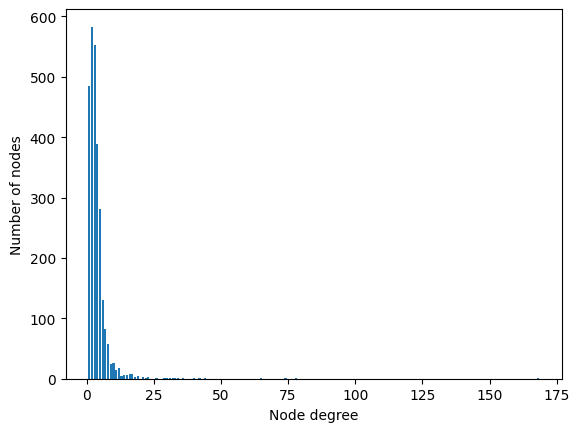

In [11]:
# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [12]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, epochs=100)

# Test
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.939 | Train Acc: 18.15% | Val Loss: 1.95 | Val Acc: 12.56%
Epoch  20 | Train Loss: 0.431 | Train Acc: 90.71% | Val Loss: 0.66 | Val Acc: 81.77%
Epoch  40 | Train Loss: 0.183 | Train Acc: 94.93% | Val Loss: 0.48 | Val Acc: 83.50%
Epoch  60 | Train Loss: 0.135 | Train Acc: 97.41% | Val Loss: 0.48 | Val Acc: 84.98%
Epoch  80 | Train Loss: 0.115 | Train Acc: 97.84% | Val Loss: 0.49 | Val Acc: 84.73%
Epoch 100 | Train Loss: 0.099 | Train Acc: 98.26% | Val Loss: 0.50 | Val Acc: 84.48%

GCN test accuracy: 89.68%



Για το Cora dataset, η απόδοση του GCN είναι πολύ κοντινή σε αυτή του GNN που χρησιμοποιήσαμε. Ας δοκιμάσουμε και με ένα graph attention network.

### Δημιουργία εκπαίδευση & αξιολόγηση Graph Attention Network

In [13]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

# Train
gat.fit(data, epochs=100)

# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)
Epoch   0 | Train Loss: 1.970 | Train Acc: 13.67% | Val Loss: 1.98 | Val Acc: 8.87%
Epoch  20 | Train Loss: 0.502 | Train Acc: 86.02% | Val Loss: 0.70 | Val Acc: 79.56%
Epoch  40 | Train Loss: 0.428 | Train Acc: 89.23% | Val Loss: 0.60 | Val Acc: 83.25%
Epoch  60 | Train Loss: 0.467 | Train Acc: 86.49% | Val Loss: 0.62 | Val Acc: 82.76%
Epoch  80 | Train Loss: 0.422 | Train Acc: 88.76% | Val Loss: 0.65 | Val Acc: 81.28%
Epoch 100 | Train Loss: 0.428 | Train Acc: 88.23% | Val Loss: 0.65 | Val Acc: 81.53%
GAT test accuracy: 89.19%


Για ακόμα μια φορά η απόδοση του δικτύου, δεν διαφέρει ιδιαίτερα από αυτή του "vanilla" GNN. Σε περίπτωση που είχαμε ένα πιο περίπλοκο σύνολο δεδομένων, με περισσότερα χαρακτηριστικά κόμβων και πιο περίπλοκες αλληλεπιδράσεις, το GCN ή/και το GAT αναμένουμε ότι θα έχει καλύτερη απόδοση σε σχέση με το "vanilla" GNN ή ένα "κλασικό" ANN.